# Import Libraries

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import re

# Import Data

In [153]:
TrainData=pd.read_csv("train_submissions.csv")
ProblemData=pd.read_csv("problem_data.csv")
UserData=pd.read_csv("user_data.csv")

# preproccesing

In [154]:
TrainData.isnull().sum()

user_id           0
problem_id        0
attempts_range    0
dtype: int64

In [155]:
UserData.isnull().sum()

user_id                         0
submission_count                0
problem_solved                  0
contribution                    0
country                      1153
follower_count                  0
last_online_time_seconds        0
max_rating                      0
rating                          0
rank                            0
registration_time_seconds       0
dtype: int64

In [156]:
ProblemData.isnull().sum()

problem_id       0
level_type     133
points        3917
tags          3484
dtype: int64

## Imputing miss value
Strategy for imputing the null values will be based on the ratio of occurence of the countries in the rest of the data. For example, India occured 25.6% and Bangladesh occured 13.6% and so on. We will use this ratio of all the countries to fill the missing data.

In [157]:
#Getting all the ratios
country_data = (UserData["country"].value_counts()/UserData["country"].count())
#imputing missing values
UserData["country"]= UserData["country"].fillna(pd.Series(np.random.choice(country_data.index,p=country_data.values, size=len(UserData))))

In [158]:
level_type_data = (ProblemData["level_type"].value_counts()/ProblemData["level_type"].count())
ProblemData["level_type"]= ProblemData["level_type"].fillna(pd.Series(np.random.choice(level_type_data.index,p=level_type_data.values, size=len(ProblemData))))
ProblemData["tags"].fillna("other", inplace=True)
ProblemData.fillna(ProblemData.mean(), inplace=True)

## Encoding categorical data

In [159]:
TrainData.dtypes

user_id           object
problem_id        object
attempts_range     int64
dtype: object

In [160]:
TrainData['user_id'] = TrainData['user_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
TrainData['problem_id'] = TrainData['problem_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)

In [161]:
UserData.dtypes

user_id                       object
submission_count               int64
problem_solved                 int64
contribution                   int64
country                       object
follower_count                 int64
last_online_time_seconds       int64
max_rating                   float64
rating                       float64
rank                          object
registration_time_seconds      int64
dtype: object

In [162]:
UserData['user_id'] = UserData['user_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
UserData["rank"]=UserData["rank"].replace(['beginner','intermediate','advanced','expert'],[1,2,3,4])
UserData['country'] = UserData['country'].astype('category')
UserData['country'] = UserData['country'].cat.codes

In [163]:
ProblemData.dtypes

problem_id     object
level_type     object
points        float64
tags           object
dtype: object

In [164]:
ProblemData["level_type"]=ProblemData["level_type"].replace(['A' ,"B","C","D","E","F","G","H","I","J","K","L","M","N"],
                                                          [ 1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ProblemData['problem_id'] = ProblemData['problem_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
ProblemData['tags'] = ProblemData['tags'].astype('category')
ProblemData['tags'] =ProblemData['tags'].cat.codes

## Scaling some feature

In [165]:
UserData["contribution"]=(UserData["contribution"]-UserData["contribution"].min())/UserData["contribution"].max()
ProblemData['points']=(ProblemData['points']-ProblemData['points'].min())/(ProblemData['points'].max()-ProblemData['points'].min())

## add new feature
add new feature as duration(days) that user is in the platform.

In [166]:
UserData["duration"]=(UserData['registration_time_seconds']-UserData['last_online_time_seconds'])/(24*3600)
UserData=UserData.drop(["registration_time_seconds","last_online_time_seconds"],axis=1)

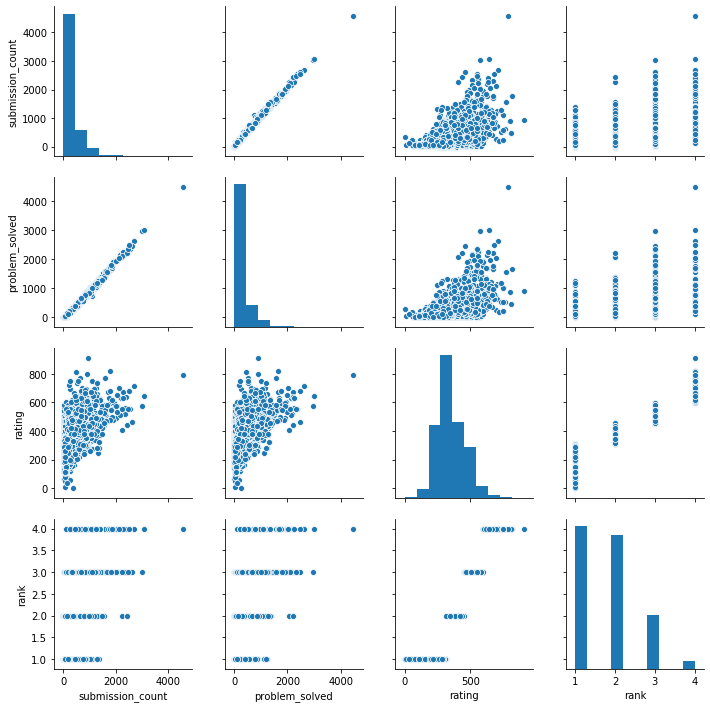

In [167]:
ax = sns.pairplot(UserData[["submission_count", "problem_solved", "rating", "rank"]])

So what do the above pair plots tell us?

1.Higher number of submissions were made by fewer number of users

2.Higher count of problems were solved by fewer number of users

3.The rating of users is uniformly spread, and most are with a rating somewhere in the middle

4.Majority users are at an intermediate and beginner level, with very few experts

5.Rating is not directly proportional to the number of problems solved or submissions - this means that difficulty level should have played a part

# Multiclass Classification

##  Merging  Files

In [168]:
df = pd.merge(TrainData,UserData,how = 'left',on = "user_id")
df = pd.merge(df,ProblemData,how = 'left',on = "problem_id")
X=df.drop("attempts_range",axis=1)
y=df["attempts_range"]

## Feature Scaling

In [169]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

## SGD Classifer

In [170]:
from sklearn.linear_model import SGDClassifier
sgd_clf1 = SGDClassifier(random_state=42)
sgd_clf1.fit(X, y)

SGDClassifier(random_state=42)

### Vadilation

In [171]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf1, X, y, cv=3, scoring="accuracy")

array([0.5326572 , 0.52790496, 0.53047426])

### Confusion matrix

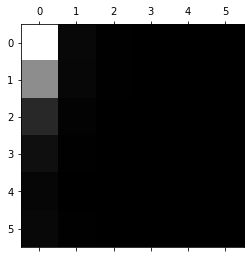

In [172]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred3 = cross_val_predict(sgd_clf1, X, y, cv=3)
conf_mx3 = confusion_matrix(y, y_pred3)
plt.matshow(conf_mx3, cmap=plt.cm.gray)
plt.show()

## Random Forest

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
forest_clf1 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 84)
forest_clf1.fit(X, y)

RandomForestClassifier(criterion='entropy', random_state=84)

### Validation

In [174]:
cross_val_score(forest_clf1, X, y, cv=5, scoring="accuracy")

array([0.50194791, 0.50548955, 0.50278502, 0.5029782 , 0.5060047 ])

### Confusion matrix

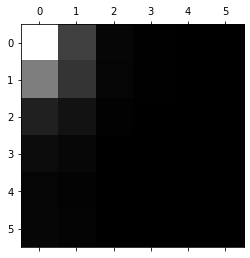

In [175]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred1 = cross_val_predict(forest_clf1, X, y, cv=3)
conf_mx1 = confusion_matrix(y, y_pred1)
plt.matshow(conf_mx1, cmap=plt.cm.gray)
plt.show()

# Resampling
why we need resampling?


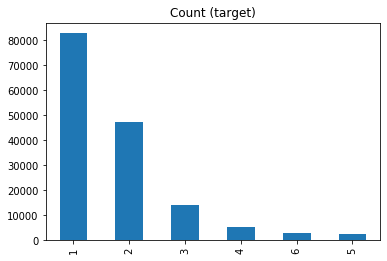

In [176]:
target_count = df.attempts_range.value_counts()
target_count.plot(kind='bar', title='Count (target)')

In [177]:
from sklearn.utils import resample

In [178]:
class6 = df[df.attempts_range==6]
class5 = df[df.attempts_range==5]
class4 = df[df.attempts_range==4]
class3 = df[df.attempts_range==3]
class2 = df[df.attempts_range==2]
class1 = df[df.attempts_range==1]
k=len(class2)

##  Oversampling Minority Class

In [179]:
class6_upsampled = resample(class6,replace=True,n_samples=k,random_state=27)
class5_upsampled = resample(class5,replace=True,n_samples=k,random_state=27)
class4_upsampled = resample(class4,replace=True,n_samples=k,random_state=27)
class3_upsampled = resample(class3,replace=True,n_samples=k,random_state=27)
class1_undersampled = resample(class1,replace=True,n_samples=k,random_state=27)
df2= pd.concat([class2,class1_undersampled,class3_upsampled,class4_upsampled,class5_upsampled,class6_upsampled])

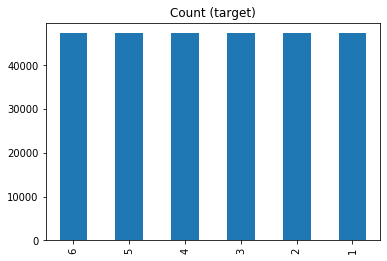

In [180]:
target_count = df2.attempts_range.value_counts()
target_count.plot(kind='bar', title='Count (target)')

## Random Forest

In [181]:
X=df2.drop(['attempts_range'],axis=1)
y=df2["attempts_range"]
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X, y)

RandomForestClassifier(random_state=42)

### Validation

In [182]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, X, y, cv=5, scoring="accuracy")

array([0.84705199, 0.84714004, 0.84719287, 0.84742181, 0.84611862])

### Confusion Matrix

[[29244 12768  3321  1135   402   450]
 [14991 21864  6340  2251   839  1035]
 [ 1269  2488 42940   329   117   177]
 [   30    81    27 47174     0     8]
 [    0     0     0     0 47320     0]
 [    0     0     0     0     0 47320]]


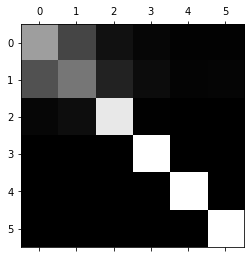

In [183]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(forest_clf, X, y, cv=3)
conf_mx = confusion_matrix(y, y_pred)
print(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# Prediction in test set

In [184]:
TestData=pd.read_csv("test_submissions.csv")
TestData['user_id'] = TestData['user_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
TestData['problem_id'] = TestData['problem_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)

In [185]:
testdf = pd.merge(TestData,UserData,how = 'left',on = "user_id")
testdf = pd.merge(testdf,ProblemData,how = 'left',on = "problem_id")
testdf=testdf.drop("ID",axis=1)
testdf["attempts_range"]=forest_clf.predict(testdf)

## Prepare for analyticsvidhya

In [188]:
DF=testdf[["user_id","problem_id","attempts_range"]]
DF["user_id"]=DF["user_id"].astype(str)
DF["problem_id"]=DF["problem_id"].astype(str)

#DF["user_id"]="user_"+DF["user_id"].astype(str)
#DF.reset_index(inplace=True)
#DF["problem_id"]="_prob_"+DF["problem_id"].astype(str)

DF["ID"]="user_"+DF["user_id"]+"_prob_"+DF["problem_id"]
DF=DF[["ID","attempts_range"]]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [189]:
DF.to_csv("Submission1.csv")

Finallay i get 0.4133366210542243.
 
 